In [1]:
import os

import matplotlib.pyplot as py
import numpy as np

from irsa.core.utils import load_spectrum, normalize_spectrum, load_peaks
from irsa.core.spectrum_functions import deconvolute, voigt
from irsa.core.algorithm import Algorithm
from irsa.core.analyses import get_spearman_and_pearson


ModuleNotFoundError: No module named 'lmfit'

Load experimental Spectrum and visualize

In [3]:
path_to_experimental_dir = f"{os.path.abspath('')}/data/experimental_spectra/"
experimental_ir_spectrum = normalize_spectrum(load_spectrum(f"{path_to_experimental_dir}/ir_cdcl3.txt"), lower=1000, upper=1500)
experimental_raman_spectrum = normalize_spectrum(load_spectrum(f"{path_to_experimental_dir}/raman_cdcl3.txt"), lower=1000, upper=1500)

Load spectrum for isomer_0, 1, 2 and 3

In [4]:
path_to_theoretical_dir = f"{os.path.abspath('')}/data/theoretical_spectra/"
theoretical_ir_spectra = []
theoretical_raman_spectra = []
for i in range(0, 4):
    theoretical_ir_spectra.append(normalize_spectrum(load_spectrum(f"{path_to_theoretical_dir}/isomer_{i}/ir_spectrum"), lower=1000, upper=1800))
    theoretical_raman_spectra.append(normalize_spectrum(load_spectrum(f"{path_to_theoretical_dir}/isomer_{i}/raman_spectrum"), lower=1000, upper=1800))

Perform deconvolution of experimental and theoretical spectra, save it to file

In [5]:

deconvolute(spectrum=experimental_ir_spectrum, working_dir=os.path.abspath(''), save_data='ir_exp_peaks.txt', normalize=True, lower=1000, higher=1500, vcd=False)
deconvolute(spectrum=experimental_raman_spectrum, working_dir=os.path.abspath(''), save_data='raman_exp_peaks.txt', normalize=True, lower=1000, higher=1500, vcd=False)
for i in range(0, 4):
    deconvolute(spectrum=theoretical_ir_spectra[i], working_dir=os.path.abspath(''), save_data=f'ir_theo_peaks_{i}.txt', normalize=True, lower=1000, higher=1800, vcd=False)
    deconvolute(spectrum=theoretical_raman_spectra[i], working_dir=os.path.abspath(''), save_data=f'raman_theo_peaks_{i}.txt', normalize=True, lower=1000, higher=1800, vcd=False)

Load peaks and concatenate them accordingly

Notice the use of kind of spectra. The numbers are arbitrary, however, 2 is reserved for VCD, since it allows for negative intensities.
If you want to apply the algorithm for any other spectroscopy methods, you can just replace the numbers. Also, if you have more types, u can also accound for this, by just appending another integer.
Notice that you would have to adapt the scoring function in irsa.core.algorithm

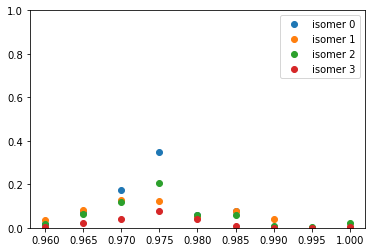

In [8]:
exp_peaks = load_peaks(paths=[f"{os.path.abspath('')}/ir_exp_peaks.txt", f"{os.path.abspath('')}/raman_exp_peaks.txt"], kind_of_spectra=[0, 1]) # first IR (0), second Raman (1), vcd would be (2)
scs = [0.96, 0.965, 0.970, 0.975, 0.980, 0.985, 0.99, 0.995, 1]
for i in range(0, 4):
    theo_peaks = load_peaks(paths=[f"{os.path.abspath('')}/ir_theo_peaks_{i}.txt", f"{os.path.abspath('')}/raman_theo_peaks_{i}.txt"], kind_of_spectra=[0, 1])
    combined_values = []
    for sc in scs:
        algo = Algorithm(exp_peaks=exp_peaks, theo_peaks=theo_peaks, lower_bound=1000, upper_bound=1500, sc=sc, cutoff=0.01)
        return_value, old_freq, freq, inten, new_sigma, new_eta, kind_of_spectrum = algo.needleman()
        x_ir, y_ir = voigt(freqs=freq[kind_of_spectrum==0], inten=inten[kind_of_spectrum==0], new_sigma=new_sigma[kind_of_spectrum==0], new_eta=new_eta[kind_of_spectrum==0]) # get convoluted ir Spectrum
        x_raman, y_raman = voigt(freqs=freq[kind_of_spectrum==1], inten=inten[kind_of_spectrum==1], new_sigma=new_sigma[kind_of_spectrum==1], new_eta=new_eta[kind_of_spectrum==1]) # get convoluted raman Spectrum
        pearson_ir, spearman_ir = get_spearman_and_pearson(spectrum_exp=experimental_ir_spectrum, spectrum_theo=np.concatenate([x_ir[:, np.newaxis], y_ir[:, np.newaxis]], axis=-1))
        pearson_raman, spearman_raman = get_spearman_and_pearson(spectrum_exp=experimental_raman_spectrum, spectrum_theo=np.concatenate([x_raman[:, np.newaxis], y_raman[:, np.newaxis]], axis=-1))
        combined_values.append(pearson_ir*spearman_ir*pearson_raman*spearman_raman*return_value)
    py.plot(scs, combined_values, "o",label=f"isomer {i}")
py.ylim(0, 1)
py.legend()
py.show()
